<a href="https://colab.research.google.com/github/Minatozaki0911/summerIntern203/blob/master/COVID_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install keras

In [3]:
 import keras
 from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
 from keras.models import Model, Sequential
 from keras.preprocessing.image import ImageDataGenerator
 from keras.models import load_model
 import numpy as np
 import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [5]:
path = '/content/drive/MyDrive/Dataset/CT_COVID'

In [88]:
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(path, 
                                               target_size=(224,224),
                                               batch_size=BATCH_SIZE,
                                               color_mode='grayscale',
                                               class_mode='binary',
                                               shuffle=True,
                                               subset='training')
validation_generator = datagen.flow_from_directory(path, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               color_mode='grayscale',
                                               class_mode='binary',
                                               shuffle=True,
                                               subset='validation')

Found 1986 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [7]:
def VGG16():
  model = Sequential()
  model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(224,224,1)))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, 3, padding='same', activation='relu'))
  model.add(Conv2D(32, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
model = VGG16()
model.summary()

In [9]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['acc'])

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "COVID_VGG16_checkpoint.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [ ]:
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    shuffle=True,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpoint_cb, early_stopping_cb])

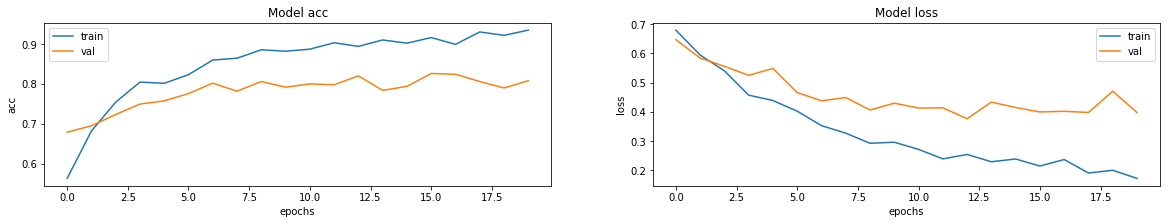

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [70]:
model.evaluate(validation_generator)

16/16 [==============================] - 15s 931ms/step - loss: 0.3919 - acc: 0.7980


[0.39186152815818787, 0.7979797720909119]

In [26]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
model.save("COVID_VGG16_Model")
model.save("COVID_VGG16.h5")

INFO:tensorflow:Assets written to: COVID_VGG16_Model/assets


In [170]:
test_path = '/content/drive/MyDrive/Colab Notebooks/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="grayscale",
    classes=['test'],
    class_mode='binary',
    batch_size=1,
    shuffle=False)
print(test_generator.filenames)


Found 9 images belonging to 1 classes.
['test/covid-19-pneumonia-182.jpg', 'test/covid-19-pneumonia-30.jpg', 'test/covid-19-pneumonia-56.jpg', 'test/covid-19-pneumonia-94.png', 'test/normal-chest-ct-1 (1).jpg', 'test/normal-chest-ct-1 (2).jpg', 'test/normal-chest-ct-1 (3).jpg', 'test/normal-chest-ct-1 (5).jpg', 'test/normal-chest-ct-1 (6).png']


In [171]:
predictions = new_model.predict(test_generator)
for i in range(0, (test_generator.labels.shape[0])):
  if predictions[i] > 0.005:
    print(test_generator.filenames[i] + 'is normal')
  else:
    print(test_generator.filenames[i] + 'is COVID')

test/covid-19-pneumonia-182.jpgis COVID
test/covid-19-pneumonia-30.jpgis normal
test/covid-19-pneumonia-56.jpgis COVID
test/covid-19-pneumonia-94.pngis COVID
test/normal-chest-ct-1 (1).jpgis COVID
test/normal-chest-ct-1 (2).jpgis normal
test/normal-chest-ct-1 (3).jpgis normal
test/normal-chest-ct-1 (5).jpgis normal
test/normal-chest-ct-1 (6).pngis normal
